In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpim
import os
%matplotlib inline

In [2]:
caldir = 'camera_cal'
calims = [os.path.join(os.getcwd(), caldir, fname) for fname in os.listdir(caldir)]
for fname in calims[:]:
    calim = mpim.imread(fname)
    print(fname)
#     plt.figure(figsize=(16,9));plt.imshow(calim)

/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/calibration01.jpg
/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/calibration02.jpg
/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/calibration03.jpg
/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/calibration04.jpg
/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/calibration05.jpg
/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/calibration06.jpg
/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/calibration07.jpg
/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/calibration08.jpg
/mnt/c/Users/Ryan Arya Pratama/Dropbox/Udacity SDC/P2_RYA_CarND_Advanced_Lane_lines/camera_cal/c

True


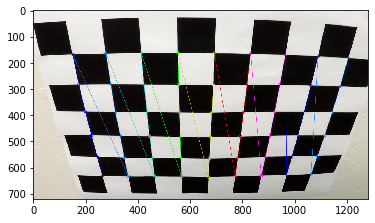

In [3]:
# Build pipeline with one test image

im = mpim.imread(calims[1])
plt.figure();plt.imshow(im)
nrow, ncol = (6, 9)
ret, corners = cv2.findChessboardCorners(im, (nrow, ncol))
print(ret)
if ret:
    cv2.drawChessboardCorners(im, (6, 9), corners, ret)
    plt.imshow(im)

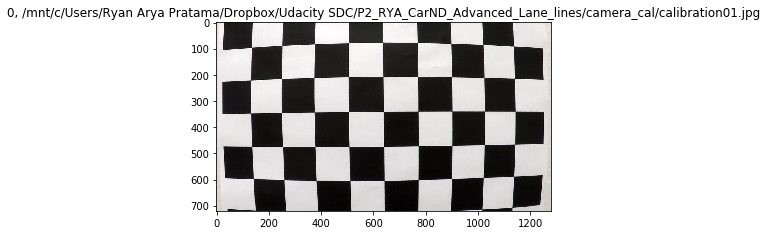

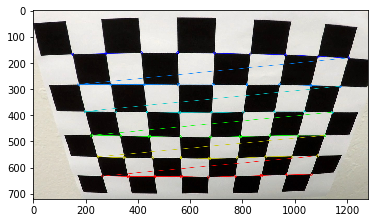

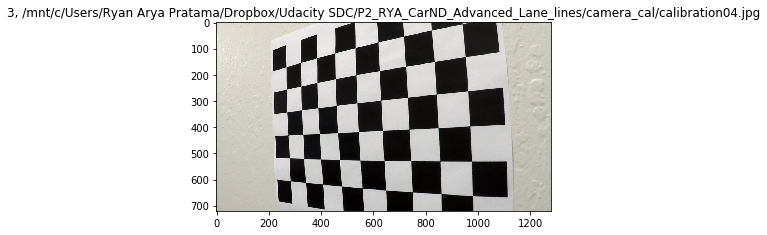

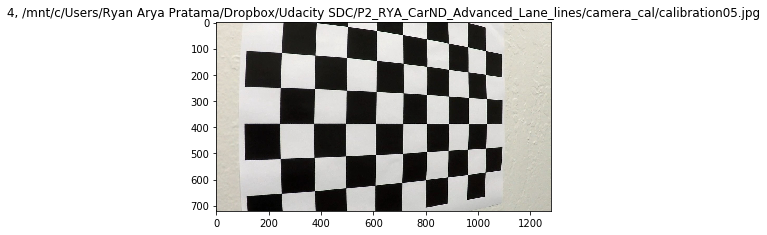

In [4]:
# First calibratioin image has different rows because of framing, 
# find out if there are other images with similar problems

for i, fname in enumerate(calims):
    im = mpim.imread(fname)
    nrow, ncol = (6, 9)
    ret, corners = cv2.findChessboardCorners(im, (ncol, nrow))
    if not ret:
        header = '{:d}, {}'.format(i, fname)
        plt.figure();plt.imshow(im)
        a = plt.gca()
        a.set_title(header)
    if i == 1:
        cv2.drawChessboardCorners(im, (ncol, nrow), corners, ret)
        plt.figure();plt.imshow(im)

In [ ]:
print(np.mgrid[0:3, 0:4])
print(np.mgrid[0:3, 0:4].T.shape)
print(np.mgrid[0:3, 0:4].reshape(-1, 2))
print(np.mgrid[0:3, 0:4].T)

In [5]:
# Calibration functions go here
caldir = 'camera_cal'
calims = [os.path.join(os.getcwd(), caldir, fname) for fname in os.listdir(caldir)]

ncol, nrow = (9, 6)
objpts = np.array([[x, y, 0] for y in range(nrow) for x in range(ncol)], np.float32)

impts = []
obpts = []

for fname in calims:
    im = mpim.imread(fname)
    ret, corners = cv2.findChessboardCorners(im, (ncol, nrow))
    if ret:
        impts.append(corners)
        obpts.append(objpts)
        
# print(im.shape[1::-1])
ret, mtx, dsc, tvx, rvx = cv2.calibrateCamera(obpts, impts, im.shape[1::-1], None, None)
print(ret)

0.9231135540074391


Text(0.5, 1.0, 'undistorted')

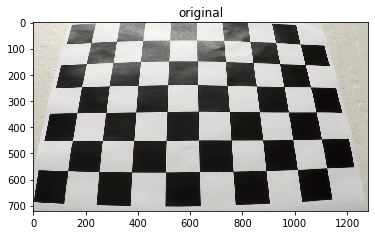

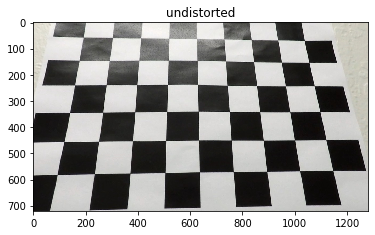

In [6]:
# Calibration verification
src = mpim.imread(calims[2])
dst = cv2.undistort(src, mtx, dsc, None, mtx)
plt.figure();plt.imshow(src);plt.gca().set_title('original')
plt.figure();plt.imshow(dst);plt.gca().set_title('undistorted')

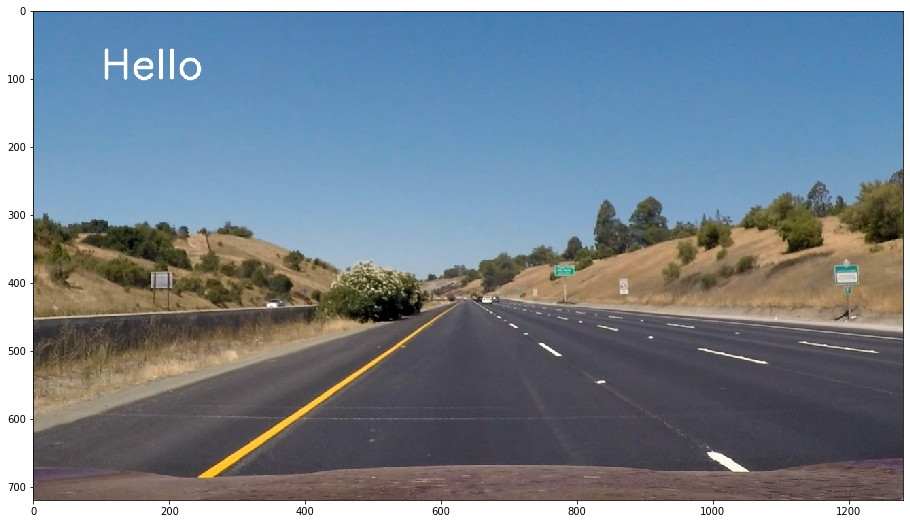

In [7]:
# Practice text drawing
testdir = 'test_images'
testfiles = [os.path.join(os.getcwd(), testdir, f) for f in os.listdir(testdir)]

im = mpim.imread(testfiles[0])
cv2.putText(im, "Hello", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3, cv2.LINE_AA)

plt.figure(figsize=(16, 9));plt.imshow(im)

In [8]:
def im_by_ref(im=None):
    if im is None:
        print('nothing given, nothing returned')
    else:
        cv2.putText(im, "hello", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        ymax, xmax, _ = im.shape
        
        cv2.rectangle(im, (xmax//4, 3*ymax//4), (3*xmax//4, ymax//4), (255, 0, 0), 2)

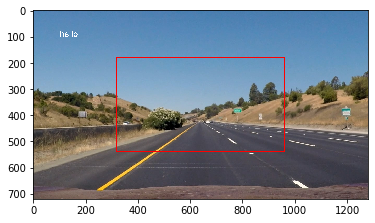

In [9]:
im = mpim.imread(testfiles[0])
im_by_ref(im)

plt.figure();plt.imshow(im)

In [ ]:
# encapsulate pipeline in a function

# parameters
sobel_ksize = 3
sobelx_th = (10, 128)
sobelg_th = (np.pi/4-np.pi/9, np.pi/4+np.pi/9) # 45 +/- 15 [deg]
sat_th = (128, 255)

# parameters
nwindows = 10
margin = 100 # window half-width, from current centre
minpix = 1000 # minimum nonzero pixel in window for recentring

def find_lane_lines(im, verbose=False):
    # undistort image
    imud = cv2.undistort(im, mtx, dsc, None, mtx)
    if verbose:
        plt.figure(figsize=(8, 4.5));plt.imshow(imud)

    # prepare sobel binary
    grey = cv2.cvtColor(imud, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(grey, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    sobelx_bin = np.zeros_like(sobelx)
    sobelx_bin[(sobelx > sobelx_th[0]) & (sobelx <= sobelx_th[1])] = 1

    sobely = cv2.Sobel(grey, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
    sobely = np.absolute(sobely)
    sobely = np.uint8(255*sobely/np.max(sobely))
    sobely_bin = np.zeros_like(sobely)
    sobely_bin[(sobely > sobelx_th[0]) & (sobely <= sobelx_th[1])] = 1

    # find gradient
    sobelg = np.arctan2(sobely, sobelx)
    sobelg_bin = np.zeros_like(sobelg, dtype=np.uint8)
    sobelg_bin[(sobelg > sobelg_th[0]) & (sobelg <= sobelg_th[1])] = 1
    
    # merge sobel intermediates
    sobelmerge = sobelg_bin & sobelx_bin

    if verbose: 
        plt.figure(figsize=(16, 9))
        plt.subplot(2, 2, 1);plt.imshow(sobelx_bin, cmap='gray')
        plt.subplot(2, 2, 2);plt.imshow(sobely_bin, cmap='gray')
        plt.subplot(2, 2, 3);plt.imshow(sobelg_bin, cmap='gray')
        plt.subplot(2, 2, 4);plt.imshow(sobelmerge, cmap='gray')

    # prepare hsl binary
    # raw to hsl
    imhsl = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
    
    # apply s-channel threshhold
    imsat = imhsl[:, :, 2]
    imsat_bin = np.zeros_like(imsat)
    imsat_bin[(imsat > sat_th[0]) & (imsat <= sat_th[1])] = 1

    # display each channel
    if verbose:
        plt.figure(figsize=(16, 9))
        plt.subplot(2, 2, 1);plt.imshow(imhsl[:, :, 0], cmap='gray');plt.gca().set_title('hue')
        plt.subplot(2, 2, 2);plt.imshow(imhsl[:, :, 1], cmap='gray');plt.gca().set_title('lit')
        plt.subplot(2, 2, 3);plt.imshow(imhsl[:, :, 2], cmap='gray');plt.gca().set_title('sat')
        plt.subplot(2, 2, 4);plt.imshow(imsat_bin, cmap='gray');plt.gca().set_title('bin')    

    # merge binaries
    # imcmb = imsat_bin | sobelmerge
    imcmb_bin = sobelmerge | imsat_bin
    imcmb = np.dstack((sobelmerge, imsat_bin, np.zeros_like(imsat_bin)))*255
    
    if verbose:
        plt.figure(figsize=(8, 4.5));plt.imshow(imcmb)
        
    # parameters for perspective transform. From bottom right counter-clockwise
    ymax, xmax = imcmb_bin.shape
    # these are read out manually
    src = np.float32([(1112, 719),
                      ( 767, 500),
                      ( 523, 500),
                      ( 219, 719)])

    # pick these for a nice dimension
    dst = np.float32([(1112, 719),
                      (1112, 0),
                      ( 219, 0),
                      ( 219, 719)])

    permat = cv2.getPerspectiveTransform(src, dst)
    invmat = cv2.getPerspectiveTransform(dst, src) # to reverse the perspective transform later
    imbird = cv2.warpPerspective(imud, permat, (xmax, ymax), flags=cv2.INTER_LINEAR)
    imbird_bin = cv2.warpPerspective(imcmb_bin, permat, (xmax, ymax), flags=cv2.INTER_LINEAR)
    
    if verbose:
        plt.figure(figsize=(16, 9))
        plt.subplot(1, 2, 1);plt.imshow(imbird)
        plt.subplot(1, 2, 2);plt.imshow(imbird_bin, cmap='gray')
        
    # find histogram for initial centres
#     ymid = imbird_bin.shape[0]//2
    ymid = 0
    hist = np.sum(imbird_bin[ymid:, :], 0)

    # calculate initial centres
    xmid = imbird_bin.shape[1]//2
    cur_leftx = np.argmax(hist[:xmid])
    cur_rightx = np.argmax(hist[xmid:]) + xmid
    xmax = imbird_bin.shape[1]

    # corrollaries
    winheight = imbird_bin.shape[0]//nwindows

    # bookkeeping
    nonzero = np.nonzero(imbird_bin)
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    llane_idx = []
    rlane_idx = []

    imout = np.dstack([imbird_bin, imbird_bin, imbird_bin])*255

    for i in range(nwindows):
        # yrange of window under consideration
        winy_top = imbird_bin.shape[0] - (i+1)*winheight
        winy_bot = imbird_bin.shape[0] - i*winheight

        # xrange of window under consideration (left and right)
        lwinx_l = np.max((0, cur_leftx - margin))
        lwinx_r = np.min((xmax, cur_leftx + margin))

        rwinx_l = np.max((0, cur_rightx - margin))
        rwinx_r = np.min((xmax, cur_rightx + margin))

        # draw current window
        if verbose:
            cv2.rectangle(imout, (lwinx_l, winy_bot), (lwinx_r, winy_top), [0, 255, 0], 2) # left
            cv2.rectangle(imout, (rwinx_l, winy_bot), (rwinx_r, winy_top), [0, 255, 0], 2) # right

        lgoed = ((nonzerox > lwinx_l) & (nonzerox <= lwinx_r) & \
                 (nonzeroy <= winy_bot) & (nonzeroy > winy_top)).nonzero()[0]
        rgoed = ((nonzerox > rwinx_l) & (nonzerox <= rwinx_r) & \
                 (nonzeroy <= winy_bot) & (nonzeroy > winy_top)).nonzero()[0]

        llane_idx.append(lgoed)
        rlane_idx.append(rgoed)

        if len(lgoed) >= minpix:
            cur_leftx = np.int(np.mean(nonzerox[lgoed]))
        if len(rgoed) >= minpix:
            cur_rightx = np.int(np.mean(nonzerox[rgoed]))

    llane_idx = np.concatenate(llane_idx)
    rlane_idx = np.concatenate(rlane_idx)

    lx = nonzerox[llane_idx]
    ly = nonzeroy[llane_idx]
    rx = nonzerox[rlane_idx]
    ry = nonzeroy[rlane_idx]

    # fit line
    lcoef = np.polyfit(ly, lx, 2)
    rcoef = np.polyfit(ry, rx, 2)

    yfit = np.linspace(0, imbird_bin.shape[0]-1, imbird_bin.shape[0])
    lxfit = lcoef[0]*yfit**2 + lcoef[1]*yfit + lcoef[2]
    rxfit = rcoef[0]*yfit**2 + rcoef[1]*yfit + rcoef[2]

    # show result
    if verbose:
        imout[ly, lx] = [255, 0, 0]
        imout[ry, rx] = [0, 0, 255]
        plt.figure(figsize=(16, 9))
        plt.plot(lxfit, yfit, 'c-')
        plt.plot(rxfit, yfit, 'm-')
        plt.imshow(imout)
        
    # draw polygon bounded by the fitted lane lines
    lpts = np.vstack((lxfit, yfit))
    lpts = np.transpose(lpts)

    rpts = np.vstack((rxfit, yfit))
    rpts = np.transpose(rpts)
    rpts = np.flipud(rpts)

    ppts = np.vstack((lpts, rpts))

    impoly = np.zeros_like(imout)
    cv2.fillPoly(impoly, np.int_([ppts]), (0, 255, 0))

    # inverse perspective to camera view (undistorted)
    impolypers = cv2.warpPerspective(impoly, invmat, (imud.shape[1], imud.shape[0]))

    # sum images
    imsum = cv2.addWeighted(imud, 1, impolypers, 0.5, 0)
    
    if verbose:
        plt.figure(figsize=(16, 9));plt.imshow(imsum)
        
    return imsum

In [ ]:
prdir = 'project_frames'
prframes = [os.path.join(prdir, fname) for fname in os.listdir(prdir)]
for i, tf in enumerate(prframes[::4]):
    im = mpim.imread(tf)
    imout = find_lane_lines(im)
    plt.figure(figsize=(8, 4.5));plt.imshow(imout)
    plt.gca().set_title('{:d}: {}'.format(i, tf.split('/')[-1]))